### Library import

In [1]:
import sys
import os
import serial
import csv
import time
import pandas as pd
import functools
import numpy as np
import random as rd
import matplotlib
import threading
from numpy import diff
import seaborn as sns



import matplotlib.pyplot as plt
import numpy as np

from matplotlib.pyplot import figure

plt.rcParams["figure.figsize"] = (20,3)



In [ ]:
import data_read

In [2]:
import helpers

### Functions

### Data capture

In [3]:
### Define constants
samples_to_capture = 1
serial_length = 2048  # Length of the serial comm message
n_sensors = 3  #  Number of sensors

### Initiate serial port communications
ser = serial.Serial('/dev/ttyACM0', baudrate=115200)
ser.flushInput()

### Clear data tensor
received_data = np.zeros([samples_to_capture,  # Define tensor to store captured data
                          n_sensors,
                          serial_length])

for i in range(samples_to_capture):
    for j in range(n_sensors):
        temp_data = []  # To store temporal data

        for k in range(serial_length):
            line = ser.readline()  # Read serial port input data
            if line:
                string = line.decode() # Decode serial data
                temp_data.append(string.split('\r')[0])  # Save data to temporal storage
        
        temp_data = [2.5 if (len(data)!=4) else data for data in temp_data]
        received_data[i, j, :] = temp_data  # Move data from temporal storage to the tensor

ser.close()

In [ ]:
sample = received_data[0][0]
plt.plot(np.arange(0, len(sample)), sample, label = 'Initial function')  # Plot the derivate function

### Data cleaning and preparation

Pulse center point:  365
Echo center point:  [596]


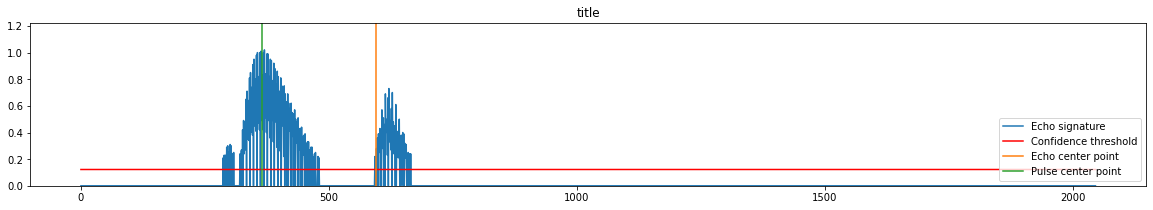

Echo distance 0 -> 0.282975 [m]
Output space indexes:  [11]
Pulse center point:  351
Echo center point:  [615]


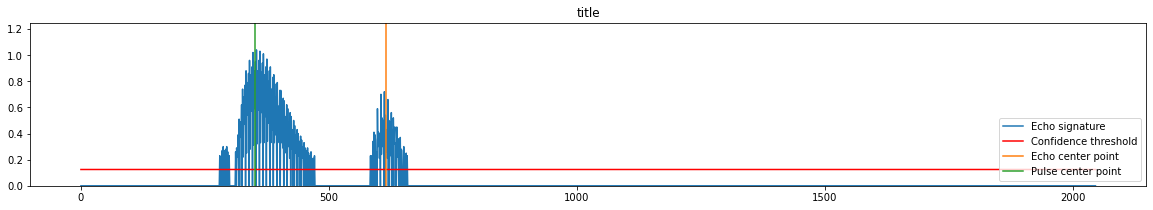

Echo distance 0 -> 0.3234 [m]
Output space indexes:  [12]
Pulse center point:  365
Echo center point:  [604]


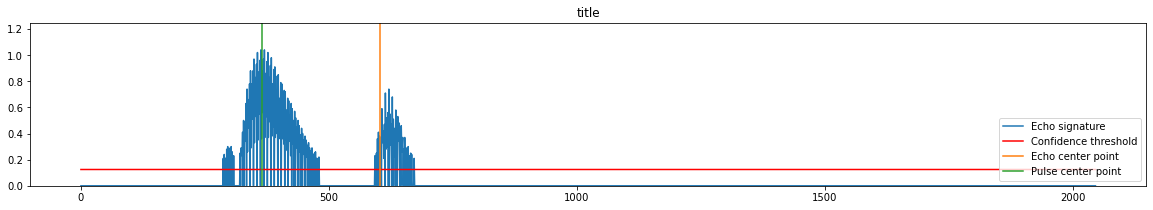

Echo distance 0 -> 0.292775 [m]
Output space indexes:  [11]


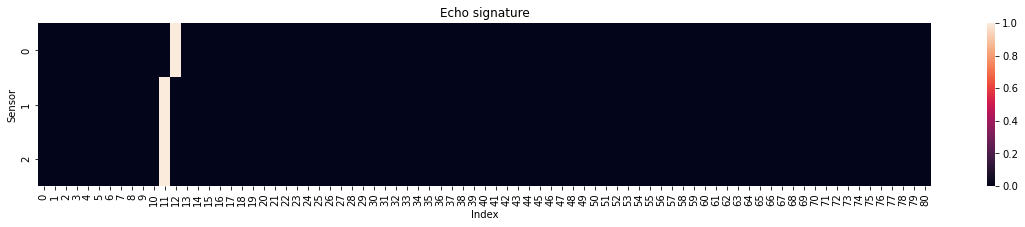

In [4]:
curated_data = np.zeros([samples_to_capture, n_sensors, 81])

for i in range(samples_to_capture):
    for j in range(n_sensors):
        
        ## Define sample to analize
        
        sample = received_data[i-1, j-1, :].astype(float)
        
        ## Apply derivate and noise reduction techniques
        
        sample_denoised = helpers.derivate_and_noise_reduction(sample, False)
       
        ## Detect pulses and retrieve related sample indexes
        
        center_point_pulse, center_point = helpers.pulse_detection(sample_denoised, True)

        ## Transform sample dimention to match ML algorithm input dimention
        
        output_space = helpers.dimention_transformation(center_point_pulse, center_point, True)
        
        for pulse_idx in output_space:
            curated_data[i-1, j-1, pulse_idx] = 1

        print('Output space indexes: ',output_space)

    sns.heatmap(curated_data[0, :, :])
    plt.xlabel('Index')
    plt.ylabel('Sensor')
    plt.title('Echo signature')
    plt.show()

In [ ]:
curated_data = np.zeros([samples_to_capture, n_sensors, 81])

for i in range(samples_to_capture):
    for j in range(n_sensors):
        
        ## Define sample to analize
        
        sample = received_data[i-1, j-1, :].astype(float)
        
        ## Derivate

        dx = 1 # Define derivate step
        dy = np.abs(diff(sample)/dx) # Derivate the raw data and take absolute value

        plt.plot(np.arange(0, len(dy)), dy, label = 'Derivate function')  # Plot the derivate function

        ### Noise reduction

        limit = max(dy)  # Calculate max value
        threshold = 0.2  # Set threshold value
        dy = [0 if (val < threshold*limit) else val for val in dy]  # All values below (threshold*limit) will be turned into 0 

        plt.plot(np.arange(0, len(dy)), dy, label = "Derivate w/ noise reduction")
        plt.plot(np.arange(0, len(dy)), [threshold*limit for i in range(len(dy))], label = "Noise reduction threshold")

        ### Plot results

        plt.title('Before and after derivate and noise reduction techniques')
        plt.xlim([0,2048])
        plt.legend(loc = 'upper right')
        plt.show()
        
        
        ### Define sample to analize

        sample = dy
        ax_y = np.arange(0, len(sample))
        plt.plot(ax_y, sample, label = "Echo signature")  #Plot sample data

        ### Define a confidence threshold to compute the mean-criteria to detect the pulses

        threshold = 0.12*max(sample)
        confidence_threshold = [threshold for i in range(len(sample))]
        plt.plot(ax_y,confidence_threshold, color = 'red', label = 'Confidence threshold')

        ### Calculate the echo/echoes center

        echo_plot_y = [i for i in range(3)]
        center_point = echo_center_point(sample, threshold)[0]

        for i in range(len(center_point)): 
            echo_plot_x = [center_point[i] for j in range(len(echo_plot_y))]
            plt.plot(echo_plot_x, echo_plot_y, label = 'Echo center point')

        ### Calculate the pulse center

        center_point_pulse = int(echo_center_point(sample, threshold)[1])
        echo_plot_x = [center_point_pulse for i in range(len(echo_plot_y))]
        plt.plot(echo_plot_x, echo_plot_y, label = 'Pulse center point')

        ### Plot and print results

        print('Pulse center point: ', center_point_pulse)
        print('Echo center point: ', center_point)

        plt.ylim([0, 1.2*max(sample)])
        plt.legend(loc = "lower right")
        plt.title('title')
        plt.show()

        i = 0
        for echo_point in center_point:
            print('Echo distance', i, '->' , echo_distance(echo_point, center_point_pulse), '[m]')
            i += 1
            
        initial_sample_freq = 140000  # ADC space
        final_sample_freq = 6800  # ML algorithm space

        transformation_ratio = final_sample_freq / initial_sample_freq

        output_space = [int((echo - center_point_pulse)*transformation_ratio) for echo in center_point]

        print('Output space indexes: ',output_space)
        
        for pulse_idx in output_space:
            curated_data[i-1, j-1, pulse_idx] = 1
            
    sns.heatmap(curated_data[0, :, :])
    plt.xlabel('Index')
    plt.ylabel('Sensor')
    plt.title('Echo signature')
    plt.show()